In [1]:
import os 
import sys 
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from glob import glob
import dicomsdl

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
from timeit import default_timer as timer

    
print('IMPORT OK!!!!')
os.chdir("G:/")


IMPORT OK!!!!


In [2]:
class cfg:
    max_size=256
    slice_scan_size=(96,160,160)
    liver_scan_size=(96,256,256)
    device='cuda'

mode = 'local' #submit #local


In [4]:

def do_pad_to_square(image):
    l, h, w = image.shape
    if w > h:
        pad = w - h
        pad0 = pad // 2
        pad1 = pad - pad0
        image = F.pad(image, [0, 0, pad0, pad1], mode='constant', value=0)
    if w < h:
        pad = h - w
        pad0 = pad // 2
        pad1 = pad - pad0
        image = F.pad(image, [pad0, pad1, 0, 0], mode='constant', value=0)
    return image

def do_scale_to_size(image, spacing, max_size):
    dz, dy, dx = spacing
    l, s, s = image.shape # scale to max size
    if max_size != s:
        scale = max_size / s
        print("scale", scale)
        print(dz, dy)
        print(l,s,s)
        l = int(dz / dy * l * 0.5)  # we use sapcing dz,dy,dx = 2,1,1
        l = int(scale * l)
        h = int(scale * s)
        w = int(scale * s)
        print(l,h,w)
        image = F.interpolate(
            image.unsqueeze(0).unsqueeze(0),
            size=(l, h, w),
            mode='trilinear',
            align_corners=False,
        ).squeeze(0).squeeze(0)

    return image


def dicomsdl_to_numpy_image(ds, index=0):
    info = ds.getPixelDataInfo()
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')  # number of separate planes in this image
    shape = [info['Rows'], info['Cols']]
    #print("dicom info", str(info))
    dtype = info['dtype']
    outarr = np.empty(shape, dtype=dtype)
    ds.copyFrameData(index, outarr)
    return outarr

def load_dicomsdl_dir(dcm_dir, slice_range=None):
    #print(glob(f'{dcm_dir}/*.dcm'))
    dcm_file = sorted(glob(f'{dcm_dir}/*.dcm'), key=lambda x: int(x.split('\\')[-1].split('.')[0]))
     
    #fake some slice so that it won't cause error ....
    if len(dcm_file)==1:
        dcm = dicomsdl.open(dcm_file[0])
        pixel_array = dicomsdl_to_numpy_image(dcm) 
        pixel_array = pixel_array.astype(np.float32)
        image = np.stack([pixel_array]*16)
        dz,dy,dx = 1,1,1
        return image, (dz,dy,dx)
    
    
    #------------------------------------
    if slice_range is None: 
        slice_min = int(dcm_file[0].split('\\')[-1].split('.')[0])
        slice_max = int(dcm_file[-1].split('\\')[-1].split('.')[0])+1
        slice_range=(slice_min, slice_max)

    slice_min, slice_max = slice_range
    sz0, szN = None, None

    image = []
    for s in range(slice_min, slice_max):
        f = f'{dcm_dir}/{s}.dcm'

        #dcm = pydicom.read_file(f)
        #m = dcm.pixel_array
        #m = standardize_pixel_array(dcm)

        dcm = dicomsdl.open(f)
        pixel_array = dicomsdl_to_numpy_image(dcm)
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

        #processing
        pixel_array = pixel_array.astype(np.float32)
        pixel_array = dcm.RescaleSlope * pixel_array + dcm.RescaleIntercept
        xmin = dcm.WindowCenter-0.5-(dcm.WindowWidth-1)* 0.5
        xmax = dcm.WindowCenter-0.5+(dcm.WindowWidth-1)* 0.5
        norm = np.empty_like(pixel_array, dtype=np.uint8)
        dicomsdl.util.convert_to_uint8(pixel_array, norm, xmin, xmax)

        if dcm.PhotometricInterpretation == 'MONOCHROME1':
            norm = 255 - norm
        image.append(norm)

    if 1: #check inversion
        dcm0 = dicomsdl.open(f'{dcm_dir}/{slice_min}.dcm')
        dcmN = dicomsdl.open(f'{dcm_dir}/{slice_max-1}.dcm')
        sx0, sy0, sz0 = dcm0.ImagePositionPatient
        sxN, syN, szN = dcmN.ImagePositionPatient
        if szN > sz0:
            image=image[::-1]

        dx, dy = dcm0.PixelSpacing
        dz = np.abs((szN - sz0) / (slice_max - slice_min-1))

    image = np.stack(image)
    return image, (dz,dy,dx)




In [5]:

def pre_process_slice_predictor(image):
    l,s,s = image.shape
    L,S,S = cfg.slice_scan_size

    l1 = int(S / s * l)
    image = F.interpolate(
            image.unsqueeze(0).unsqueeze(0),
            size=[l1,S,S],
            mode='trilinear'
        ).squeeze(0).squeeze(0)

    # pad or crop to max length L
    if L > l1:
        image = F.pad(image, [0, 0, 0, 0, 0, L - l1], mode='constant', value=0)
    if L < l1:
        image = image[:L]
    return image

def post_process_slice_predictor(x, image, slice_prob):
    l,s,s = x.shape
    L,S,S = image.shape

    l1 = int(S / s * l)
    p = F.interpolate(
            slice_prob.unsqueeze(0),
            size=[l1],
            mode='linear'
        ).squeeze(0).squeeze(0)

    # unpad or uncrop to max length L
    if L > l1:
        p = F.pad(p, [0, L - l1], mode='constant', value=0)
    return p

#---

def pre_process_liver_predictor(image, slice_predict):
    z = torch.where(slice_predict > 0)[0]
    if len(z)==0:
        z0, z1 = 0, 96 
    else: 
        z0, z1 = z.min().item(), z.max().item()

    sub_image = image[z0:z1]

    L,S,S = cfg.liver_scan_size
    zz=0
    sub_image = F.interpolate(
        sub_image.unsqueeze(0).unsqueeze(0),
        size=[L,S,S],
        mode='trilinear'
    ).squeeze(0).squeeze(0)
    return sub_image

print('DATASET SETTING OK!!!!')


DATASET SETTING OK!!!!


In [5]:
# mode = 'local' #submit #local

# if mode =='local':
#     image_dir  = './rsna-2023-abdominal-trauma-detection/train_images'
#     #series_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
#     fold_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-weight-00/valid_df.fold2.csv') 
#     fold_df = fold_df[:20]    
#     valid_id  = list(zip(fold_df.patient_id, fold_df.series_id))
         
#     train_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv') 
#     valid_df = train_df[train_df.patient_id.isin(fold_df.patient_id)].reset_index(drop=True)

    
# if mode =='submit':
#     image_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
#     series_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv')
#     valid_df  = pd.read_csv( '/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv') 
#     valid_id  = list(zip(series_df.patient_id, series_df.series_id))
 
    

# patient_id = valid_df.patient_id.unique()
    
# print('len(patient_id)',len(patient_id))   
# print('patient_id',patient_id[:10])   
# print('')
 
# print('len(valid_id)',len(valid_id))   
# print('valid_id',valid_id[:10]) 
# print('')

# #---


# print('MODE SETTING OK!!!!')


In [6]:
dicom_tag_columns = [
    'BitsAllocated',
    'BitsStored',
    'Columns',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'PatientID',
    'PatientPosition',
    'PixelRepresentation',
    'PixelSpacing',
    'RescaleIntercept',
    'RescaleSlope',
    'Rows',
    'SeriesNumber',
    'SeriesInstanceUID',
    'SliceThickness',
    'path',
    'WindowCenter',
    'WindowWidth'
]

train_dicom_tags = pd.read_parquet('./rsna-2023-abdominal-trauma-detection/train_dicom_tags.parquet', columns=dicom_tag_columns)
test_dicom_tags = pd.read_parquet('./rsna-2023-abdominal-trauma-detection/test_dicom_tags.parquet', columns=dicom_tag_columns)


In [7]:
import os
os.listdir()

['$RECYCLE.BIN',
 '.vscode',
 '0818',
 '0819',
 '101.dcm',
 'archive (2)',
 'CLIP-Driven-Universal-Model',
 'debug.log',
 'kits23',
 'model_0.pth',
 'model_1.pth',
 'rsna-2023-abdominal-trauma-detection',
 'rsna-abdominal-2023',
 'RSNA2022RAWE',
 'SAM-Med2D',
 'sentence-transformers-2.2.2.zip',
 'StableDiffusion',
 'SyntheticTumors-main',
 'SyntheticTumors-main.zip',
 'System Volume Information',
 'test_X.npy',
 'train_data.csv',
 'train_X.npy',
 'Unconfirmed 325799.crdownload',
 'vit0918_model_0.pth',
 'vit0918_model_1.pth',
 'vit_model_0.pth',
 'vit_model_1.pth']

In [8]:
image, (dz, dy, dx) = load_dicomsdl_dir("./rsna-2023-abdominal-trauma-detection/train_images/19/14374", slice_range=None) #byte
image = torch.from_numpy(image).float()


In [9]:
image.shape

torch.Size([673, 512, 512])

In [10]:
image1 = do_pad_to_square(image)


In [11]:
image2 = do_scale_to_size(image1, (dz, dy, dx), max_size=cfg.max_size) #torch.Size([193, 256, 256])


scale 0.5
0.7999999999999998 0.904
673 512 512
148 256 256


In [12]:
image1.shape, image2.shape

(torch.Size([673, 512, 512]), torch.Size([148, 256, 256]))

In [13]:
len(glob("./rsna-2023-abdominal-trauma-detection/train_images/*/*/*"))

1571194

In [14]:

from sklearn.model_selection import KFold, GroupKFold
from glob import glob
train_csv = pd.read_csv(f'./rsna-2023-abdominal-trauma-detection/train.csv')

train_csv = train_csv.set_index('patient_id')
train_512_jpgs = glob('./rsna-abdominal-2023/reduced_512_tickness_5/*/*/*.jpeg')
pids = list(train_csv.index)

train_data = ([x for x in train_512_jpgs if int(x.split('\\')[-3]) in pids[:-200]])
train_data = train_data[::20]
train_p_id = [int(x.split('\\')[-3]) for x in train_data]
train_df = pd.DataFrame({"path":train_data,"patient_id":train_p_id})
gkf = KFold(n_splits=4)
for i, (train_index, val_index) in enumerate(gkf.split(train_df, groups=train_df["patient_id"])):
    train_df.loc[val_index, "fold"] = i


In [15]:
X_train = train_df[train_df["fold"] != 0]
X_train.reset_index(drop=True)


,path,patient_id,fold
0,./rsna-abdominal-2023/reduced_512_tickness_5\2...,2402,1.0
1,./rsna-abdominal-2023/reduced_512_tickness_5\2...,2402,1.0
2,./rsna-abdominal-2023/reduced_512_tickness_5\2...,2402,1.0
3,./rsna-abdominal-2023/reduced_512_tickness_5\2...,2402,1.0
4,./rsna-abdominal-2023/reduced_512_tickness_5\2...,2402,1.0
...,...,...,...
17118,./rsna-abdominal-2023/reduced_512_tickness_5\6...,6493,3.0
17119,./rsna-abdominal-2023/reduced_512_tickness_5\6...,6493,3.0
17120,./rsna-abdominal-2023/reduced_512_tickness_5\6...,6493,3.0
17121,./rsna-abdominal-2023/reduced_512_tickness_5\6...,6493,3.0


In [16]:
X_train.iloc[1]

path          ./rsna-abdominal-2023/reduced_512_tickness_5\2...
patient_id                                                 2402
fold                                                        1.0
Name: 5709, dtype: object

In [17]:
train_data = ([x for x in train_512_jpgs if int(x.split('\\')[-3]) in pids[:-200]])

len(pids)

3147

In [ ]:
# pids[:-200]

In [19]:
len(np.unique([int(x.split('\\')[-3]) for x in train_data]))

2947

In [20]:
len([x for x in train_512_jpgs])

487197

In [4]:
# (train_512_jpgs)
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache()

In [22]:
len([x for x in train_512_jpgs if int(x.split('\\')[-3]) in pids[:-200]])

456619

In [23]:
len(train_data)


456619

In [24]:
len(glob('./rsna-abdominal-2023/reduced_512_tickness_5/*/*/*.jpeg'))

487197

In [25]:
import nibabel as nib
p_s = glob("./rsna-2023-abdominal-trauma-detection/train_images/*/*")

s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}


In [26]:
len(s_id_p_id)

4711

In [27]:
seg_id = [x.split("\\")[-1].split(".")[0] for x in glob("./rsna-2023-abdominal-trauma-detection/segmentations/*")]

In [28]:
len(seg_id)

206

In [29]:
len([x for x in seg_id if x in s_id_p_id.keys()])

206

In [30]:
seg_id[0]

'10000'

In [31]:
s_id_p_id[seg_id[0]]

'54722'

In [1]:
(glob("./rsna-2023-abdominal-trauma-detection/train_images/54722/10000/*"))[:10]

NameError: name 'glob' is not defined

In [33]:
from monai.transforms.io.array import LoadImage
monai_loader = LoadImage()


e:\Anaconda\envs\tt\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [34]:
([x for x in seg_id if x in s_id_p_id.keys()])

['10000',
 '10109',
 '10180',
 '10252',
 '10385',
 '10494',
 '11748',
 '1201',
 '12039',
 '12102',
 '12114',
 '12402',
 '12674',
 '12840',
 '12900',
 '13041',
 '13307',
 '13666',
 '137',
 '13774',
 '13848',
 '13925',
 '14286',
 '15271',
 '15415',
 '15539',
 '15748',
 '16066',
 '16097',
 '16503',
 '17225',
 '17577',
 '17605',
 '18207',
 '18624',
 '19360',
 '19468',
 '19657',
 '19927',
 '20664',
 '20684',
 '21057',
 '21282',
 '22232',
 '22397',
 '22479',
 '22730',
 '23644',
 '23837',
 '24134',
 '24149',
 '24373',
 '24442',
 '24645',
 '24774',
 '25349',
 '25359',
 '26214',
 '26343',
 '26840',
 '26906',
 '26942',
 '26980',
 '28079',
 '28122',
 '28432',
 '29053',
 '29167',
 '29832',
 '30064',
 '30522',
 '30843',
 '30902',
 '30952',
 '31021',
 '31085',
 '31146',
 '31200',
 '31571',
 '31852',
 '32243',
 '32670',
 '32991',
 '33355',
 '33526',
 '34224',
 '34232',
 '34774',
 '35190',
 '35661',
 '36257',
 '36753',
 '37032',
 '38633',
 '39013',
 '39205',
 '39222',
 '39628',
 '397',
 '39864',
 '401

In [35]:
# total_seg_image = 0
# total_seg_layer = 0
# for s_id in seg_id:
#     total_seg_image += (len(glob(f"./rsna-2023-abdominal-trauma-detection/train_images/{s_id_p_id[s_id]}/{s_id}/*")))
#     nib_file = nib.load(f"./rsna-2023-abdominal-trauma-detection/segmentations/{s_id}.nii")
#     total_seg_layer += nib.as_closest_canonical(nib_file).get_fdata().shape[-1]
#     print(total_seg_layer, total_seg_image)
# print(total_seg_image, total_seg_layer)

In [36]:
s_id = seg_id[0]
p_id = s_id_p_id[s_id]
len(glob(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/*"))

966

In [37]:
from sklearn.model_selection import KFold, GroupKFold
from glob import glob
import pandas as pd
import numpy as np
train_csv = pd.read_csv(f'./rsna-2023-abdominal-trauma-detection/train.csv')

train_csv = train_csv.set_index('patient_id')
bowel_label = 1-train_csv[["bowel_healthy"]]
extra_label = 1-train_csv[["extravasation_healthy"]]
train_csv["kidney_label"] = (train_csv["kidney_low"]).astype(np.uint32) +  (train_csv["kidney_high"]).astype(np.uint32) * 2
kidney_label = train_csv[["kidney_label"]]
train_csv["liver_label"] = (train_csv["liver_low"]).astype(np.uint32) +  (train_csv["liver_high"]).astype(np.uint32) * 2
liver_label = train_csv[["liver_label"]]
train_csv["spleen_label"] = (train_csv["spleen_low"]).astype(np.uint32) +  (train_csv["spleen_high"]).astype(np.uint32) * 2
spleen_label = train_csv[["spleen_label"]]

In [38]:
train_label = train_csv["bowel_injury"].astype(np.uint32)+train_csv["kidney_low"].astype(np.uint32)+\
    train_csv["kidney_high"].astype(np.uint32)+train_csv["extravasation_injury"].astype(np.uint32)+\
        train_csv["liver_low"].astype(np.uint32)+train_csv["liver_high"].astype(np.uint32)+\
   train_csv["spleen_low"].astype(np.uint32)+train_csv["spleen_high"].astype(np.uint32)

In [39]:
np.sum(train_label.values==0)

2292

In [40]:
train_csv.loc[train_label>1]

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,kidney_label,liver_label,spleen_label
patient_id,,,,,,,,,,,,,,,,,
10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,2
10217,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,2
10228,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1
10300,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1
10917,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
8263,1,0,0,1,0,1,0,0,0,1,1,0,0,1,1,2,0
8848,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1


In [41]:
bowel_label.values.min()

0

In [42]:
train_csv["spleen_label"].values.max()

2

In [43]:
s_id_p_id["10000"]

'54722'

In [44]:
np.unique(kidney_label.values)

array([0, 1, 2], dtype=uint32)

In [50]:
os.getcwd()
os.path.exists(f"./rsna-abdominal-2023/labels")

False

In [ ]:
total_seg_image = 0
total_seg_layer = 0
import nibabel as nib
import pydicom
import copy
from glob import glob
import matplotlib.pyplot as plt
import dicomsdl
from skimage import measure
import cv2
p_s = glob("./rsna-2023-abdominal-trauma-detection/train_images/*/*")
seg_id = [x.split("\\")[-1].split(".")[0] for x in glob("./rsna-2023-abdominal-trauma-detection/segmentations/*")]
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
from itertools import chain
test_segments = []
test_imgs = []
for si in range(len(seg_id)):
    s_id = seg_id[si]
    p_id = s_id_p_id[s_id]
    if not os.path.exists(f"./rsna-abdominal-2023/labels/{p_id}"):
        os.mkdir(f"./rsna-abdominal-2023/labels/{p_id}")
    if not os.path.exists(f"./rsna-abdominal-2023/labels/{p_id}/{s_id}"):
        os.mkdir(f"./rsna-abdominal-2023/labels/{p_id}/{s_id}")
    # if si !=59:continue
    seg_im = nib.load(f"./rsna-2023-abdominal-trauma-detection/segmentations/{s_id}.nii")
    seg_im = nib.as_closest_canonical(seg_im)
    seg_im = seg_im.get_fdata().astype(int)[::-1,::-1, ::-1].transpose(1,0,2)
    img_files = glob(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/*.dcm")
    img_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in img_files])
    print("check file size ", len(img_files),seg_im.shape[2])
    print(p_id,s_id,len(img_files))
    # label = "1"#kidney_label.loc[int(p_id)].values[0]
    # print(train_csv.loc[int(p_id)][[x for x in train_csv.columns if "healthy" not in x]])
    # print("kidney ", label)
    #continue
    for ii in range(len(img_files)):
        # if ii!=280:continue
        # print(p_id,s_id,(img_ids[ii]))
        img_id = img_ids[ii]
        #plt.imshow(seg_im[:,:,ii])
        dcm = dicomsdl.open(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/{img_id}.dcm")
        
        pixel_array = dicomsdl_to_numpy_image(dcm)
        #print("dicom shape ", pydicom.dcmread(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/{img_id}.dcm").pixel_array.shape)
        pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max()-pixel_array.min())
        #if pixel_array.shape[1]==512:continue
        # print(p_id,s_id,ii,img_id)
        # plt.imshow(seg_im[:,:,ii])
        seg_recovered = np.zeros((512,512), dtype=np.int32)

        seg_recovered = copy.deepcopy(pixel_array)
        #print(np.unique(seg_im[:,:,ii]))
        # f1 = open(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/{img_id}.txt","w")
        # f2 = open(f"./rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}/{img_id}.txt","w")
        fc = open(f"./rsna-abdominal-2023/labels/{p_id}/{s_id}/{img_id}.txt","w")
        # fr = open(f"./rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}/{img_id}.txt","r")
        # r_coordinates = [[int(float(x)) for x in line.split()[0:]] for line in fr.readlines()]
        for jj in range(1,6):
            seg_polygon = measure.find_contours(seg_im[:,:,ii].T==jj,0.5)
            # coordinates = [x[1:] for x in r_coordinates if x[0]==jj]
            # assert len(seg_polygon)==len(coordinates)
            #plt.imshow(np.where(seg_im[:,:,ii]==jj,1,pixel_array[:,:]))
            class_im = np.zeros((512,512), dtype=np.int32)
            for kk in range(len(seg_polygon)):
                coordinates = " ".join(map(str, chain(*np.array(seg_polygon[kk]))))
                #print(f"{label} {coordinates}\n")
                # f1.write(f"{label} {coordinates}\n")
                #f2.write(f"{jj} {coordinates}\n")
                fc.write(f"{jj} {coordinates}\n")       
                # cv2.fillPoly(seg_recovered, pts=np.int32(np.array(seg_polygon[kk]).reshape(1, -1, 2)),color=(1,1,1))
                # cv2.fillPoly(class_im, pts=np.int32(np.array(coordinates[kk]).reshape(1, -1, 2)),color=(1,1,1))
            # print("count ", jj, np.sum(seg_im[:,:,ii]==jj),np.sum(class_im==1))
            # im_show =np.where(class_im[:,:]==1,1,pixel_array[:,:])
            # assert np.sum(seg_recovered==im_show) == 262144
            # plt.subplot(4, 3, jj+1);plt.imshow(im_show)
        fc.close()
            # plt.imshow(class_im)
        # # f1.close()
        #f2.close()
        # break
    # break
    #total_seg_image += (len(glob(f"./rsna-2023-abdominal-trauma-detection/train_images/{s_id_p_id[s_id]}/{s_id}/*")))


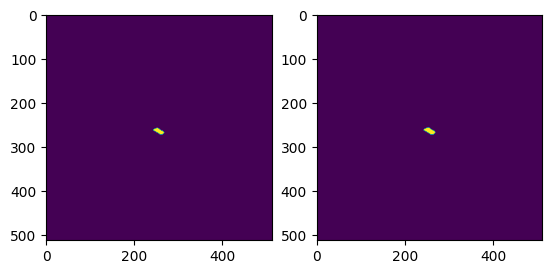

In [ ]:
plt.subplot(1,2,1);plt.imshow(seg_im[:,:,ii]==5)
plt.subplot(1,2,2);plt.imshow(class_im)


In [ ]:
pixel_array.shape

(512, 512)

In [ ]:
np.unique(seg_im[:,:,3],return_counts=True)

(array([0, 5]), array([261918,    226], dtype=int64))

In [ ]:
seg_id

In [ ]:
seg_id[55]

'25349'

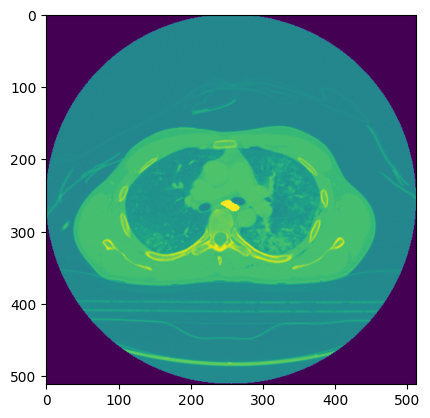

In [ ]:
plt.imshow(seg_recovered)

In [ ]:
pixel_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
np.unique(seg_im[:,:,ii])

array([0, 5])

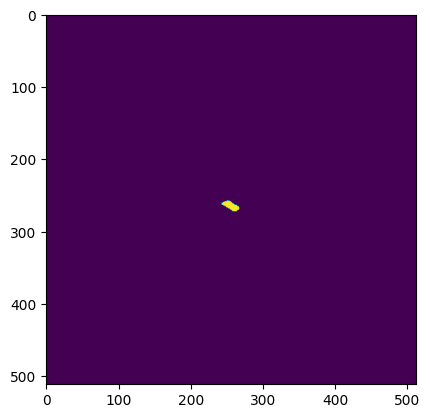

In [ ]:
plt.imshow(seg_im[:,:,ii])

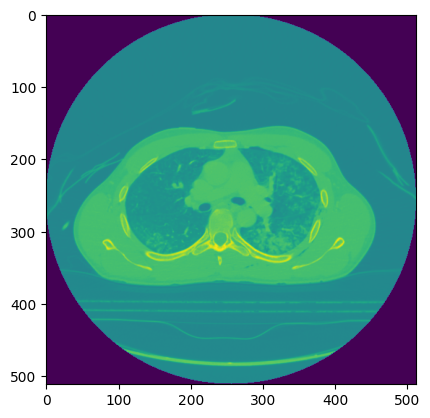

In [ ]:
plt.imshow(pixel_array)

In [ ]:
os.listdir()

['$RECYCLE.BIN',
 '.vscode',
 '0818',
 '0819',
 '101.dcm',
 'archive (2)',
 'CLIP-Driven-Universal-Model',
 'debug.log',
 'kits23',
 'model_0.pth',
 'model_1.pth',
 'rsna-2023-abdominal-trauma-detection',
 'rsna-abdominal-2023',
 'RSNA2022RAWE',
 'SAM-Med2D',
 'sentence-transformers-2.2.2.zip',
 'StableDiffusion',
 'SyntheticTumors-main',
 'SyntheticTumors-main.zip',
 'System Volume Information',
 'test_X.npy',
 'train_data.csv',
 'train_X.npy',
 'Unconfirmed 325799.crdownload',
 'vit0918_model_0.pth',
 'vit0918_model_1.pth',
 'vit_model_0.pth',
 'vit_model_1.pth']

In [ ]:
import shutil
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold

s_id_list = []
p_id_list = []
img_id_list = []
for s_id in seg_id:
    p_id = s_id_p_id[s_id]
    base_filename = f"./rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}"
    imgnames = glob(base_filename+"/*.jpeg")
    print("copying ",p_id,s_id,len(imgnames))
    img_ids = [x.split("\\")[-1].split(".")[0] for x in imgnames]
    s_id_list += [s_id]*len(img_ids)
    p_id_list += [p_id]*len(img_ids)
    img_id_list += img_ids

train_df = pd.DataFrame({"s_id":s_id_list,"p_id":p_id_list,"img_id":img_id_list})
gkf = KFold(n_splits=4)
for i, (train_index, val_index) in enumerate(gkf.split(train_df, groups=train_df["p_id"])):
    train_df.loc[val_index, "fold"] = i



copying  54722 10000 483
copying  48710 10109 250
copying  62116 10180 828
copying  34409 10252 88
copying  28925 10385 703
copying  60744 10494 245
copying  42436 11748 53
copying  50518 1201 252
copying  10937 12039 365
copying  64256 12102 583
copying  14950 12114 403
copying  65326 12402 69
copying  28569 12674 412
copying  18697 12840 221
copying  14309 12900 266
copying  11177 13041 375
copying  3506 13307 303
copying  43551 13666 269
copying  46904 137 718
copying  32272 13774 169
copying  65326 13848 190
copying  55888 13925 730
copying  57444 14286 154
copying  20621 15271 168
copying  57444 15415 187
copying  20951 15539 291
copying  37429 15748 715
copying  10217 16066 690
copying  33007 16097 319
copying  14321 16503 696
copying  64256 17225 168
copying  33848 17577 473
copying  33251 17605 167
copying  50873 18207 788
copying  37169 18624 259
copying  13623 19360 71
copying  3983 19468 243
copying  19249 19657 257
copying  19410 19927 154
copying  28095 20664 323
copying  

In [ ]:
train_df

,s_id,p_id,img_id,fold
0,10000,54722,257,0.0
1,10000,54722,258,0.0
2,10000,54722,259,0.0
3,10000,54722,260,0.0
4,10000,54722,261,0.0
...,...,...,...,...
70536,8413,14321,95,3.0
70537,8413,14321,96,3.0
70538,8413,14321,97,3.0
70539,8413,14321,98,3.0


In [ ]:
train_df[train_df["p_id"]=="64194"]

,s_id,p_id,img_id,fold
20127,25349,64194,10,1.0
20128,25349,64194,100,1.0
20129,25349,64194,101,1.0
20130,25349,64194,102,1.0
20131,25349,64194,103,1.0
...,...,...,...,...
30817,34232,64194,95,1.0
30818,34232,64194,96,1.0
30819,34232,64194,97,1.0
30820,34232,64194,98,1.0


In [ ]:
fold = 3
import os
trn_df = train_df[train_df["fold"]==fold]
os.makedirs(f"././rsna-abdominal-2023/train",exist_ok=True)
os.makedirs(f"././rsna-abdominal-2023/valid",exist_ok=True)
os.makedirs(f"././rsna-abdominal-2023/train/images",exist_ok=True)
os.makedirs(f"././rsna-abdominal-2023/train/labels",exist_ok=True)
os.makedirs(f"././rsna-abdominal-2023/valid/images",exist_ok=True)
os.makedirs(f"././rsna-abdominal-2023/valid/labels",exist_ok=True)
for i in range(len(trn_df)):
    if i%10==0:
        print(i, len(trn_df))
    row = trn_df.iloc[i]
    p_id = row["p_id"]
    s_id = row["s_id"]
    image_id = row["img_id"]
    #print("copying ",p_id,s_id,image_id)
    base_filename = f"./rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}"
    new_basename = f"./rsna-abdominal-2023/valid/"
    shutil.copyfile(base_filename+f"/{image_id}.txt",new_basename+f"labels/{p_id}_{s_id}_{image_id}.txt")
    shutil.copyfile(base_filename+f"/{image_id}.jpeg",new_basename+f"images/{p_id}_{s_id}_{image_id}.jpeg")

In [ ]:
base_dir = "E:\mmdetection-master\mmdetection-master\mmdet\datasets\data/rsna/"
base_dir = "G:/rsna-abdominal-2023/"
tr_labels = glob(f"{base_dir}/train/labels/*")
val_labels = glob(f"{base_dir}/valid/labels/*")

In [ ]:
tr_names = [x.split("\\")[-1].split(".")[0] for x in tr_labels]
val_names = [x.split("\\")[-1].split(".")[0] for x in val_labels]
len(tr_names),len(val_names)

(52906, 17635)

In [ ]:
for v_name in val_names:
    if not os.path.exists(f"{base_dir}/valid/labels/{v_name}.txt"): continue
    has_content = len(open(f"{base_dir}/valid/labels/{v_name}.txt").readlines())
    if has_content==0:
        print(v_name)
        # os.remove(f"{base_dir}/valid/labels/{v_name}.txt")
        # os.remove(f"{base_dir}/valid/images/{v_name}.jpeg")

In [ ]:
for tr_name in tr_names:
    if not os.path.exists(f"{base_dir}/train/labels/{tr_name}.txt"): continue
    has_content = len(open(f"{base_dir}/train/labels/{tr_name}.txt").readlines())
    if has_content==0:
        print(tr_name)
        os.remove(f"{base_dir}/train/labels/{tr_name}.txt")
        os.remove(f"{base_dir}/train/images/{tr_name}.jpeg")

In [ ]:
for v_name in val_names:
    if not os.path.exists(f"{base_dir}/valid/images/{v_name}.jpeg"): continue
    dim = cv2.imread(f"{base_dir}/valid/images/{v_name}.jpeg").shape
    
    if dim[1]!=512:
        print(v_name,dim)
        os.remove(f"{base_dir}/valid/labels/{v_name}.txt")
        os.remove(f"{base_dir}/valid/images/{v_name}.jpeg")

In [ ]:
for tr_name in tr_names:
    if not os.path.exists(f"{base_dir}/train/labels/{tr_name}.txt"): continue
    dim = cv2.imread(f"{base_dir}/train/images/{tr_name}.jpeg").shape
    if dim[1]!=512:
        print(tr_name,dim)
        os.remove(f"{base_dir}/train/labels/{tr_name}.txt")
        os.remove(f"{base_dir}/train/images/{tr_name}.jpeg")

In [ ]:
processed_filtered = [x.split("_")[-2] for x in glob(f"E:/mmdetection-master/mmdetection-master/mmdet/datasets/data/rsna/train/images/*.jpeg")]
processed_filtered += [x.split("_")[-2] for x in glob(f"E:/mmdetection-master/mmdetection-master/mmdet/datasets/data/rsna/valid/images/*.jpeg")]

len(set(processed_filtered))

197

In [ ]:
processed = [x.split("_")[-2] for x in glob(f"./rsna-abdominal-2023/train/images/*.jpeg")]
processed += [x.split("_")[-2] for x in glob(f"./rsna-abdominal-2023/valid/images/*.jpeg")]
processed_imgs = [x for x in glob(f"./rsna-abdominal-2023/train/images/*.jpeg")]
processed_imgs += [x for x in glob(f"./rsna-abdominal-2023/valid/images/*.jpeg")]

len(set(processed)),

(206,)

In [ ]:
[x for x in processed_imgs if x.split("_")[-2] in set(processed_filtered)]

In [ ]:
len(glob(f"./rsna-abdominal-2023/reduced_512_tickness_1/*/*"))

206

In [ ]:
processed = [x.split("_")[-3] for x in glob(f"./rsna-abdominal-2023/train/images/*.jpeg")]
processed += [x.split("_")[-3] for x in glob(f"./rsna-abdominal-2023/valid/images/*.jpeg")]
len(set(processed))

164

In [ ]:
len(glob(f"E:/mmdetection-master/mmdetection-master/mmdet/datasets/data/rsna/valid/images/*.jpeg"))

15287

In [ ]:
len(set(processed))

164

In [ ]:
seg_id

['10000',
 '10109',
 '10180',
 '10252',
 '10385',
 '10494',
 '11748',
 '1201',
 '12039',
 '12102',
 '12114',
 '12402',
 '12674',
 '12840',
 '12900',
 '13041',
 '13307',
 '13666',
 '137',
 '13774',
 '13848',
 '13925',
 '14286',
 '15271',
 '15415',
 '15539',
 '15748',
 '16066',
 '16097',
 '16503',
 '17225',
 '17577',
 '17605',
 '18207',
 '18624',
 '19360',
 '19468',
 '19657',
 '19927',
 '20664',
 '20684',
 '21057',
 '21282',
 '22232',
 '22397',
 '22479',
 '22730',
 '23644',
 '23837',
 '24134',
 '24149',
 '24373',
 '24442',
 '24645',
 '24774',
 '25349',
 '25359',
 '26214',
 '26343',
 '26840',
 '26906',
 '26942',
 '26980',
 '28079',
 '28122',
 '28432',
 '29053',
 '29167',
 '29832',
 '30064',
 '30522',
 '30843',
 '30902',
 '30952',
 '31021',
 '31085',
 '31146',
 '31200',
 '31571',
 '31852',
 '32243',
 '32670',
 '32991',
 '33355',
 '33526',
 '34224',
 '34232',
 '34774',
 '35190',
 '35661',
 '36257',
 '36753',
 '37032',
 '38633',
 '39013',
 '39205',
 '39222',
 '39628',
 '397',
 '39864',
 '401

In [ ]:
v_set = set()
for s_id in seg_id:
    seg_im = nib.load(f"./rsna-2023-abdominal-trauma-detection/segmentations/{s_id}.nii")
    seg_im = nib.as_closest_canonical(seg_im)
    seg_im = seg_im.get_fdata().astype(int)[::1, ::1, :]
    v_set.update(np.unique(seg_im))
print(v_set)


{0, 1, 2, 3, 4, 5}


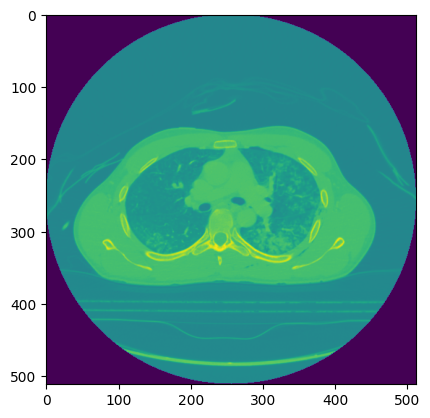

In [ ]:

plt.imshow(pixel_array)

In [ ]:
print(pixel_array.shape,seg_im.shape)

(512, 512) (512, 512, 324)


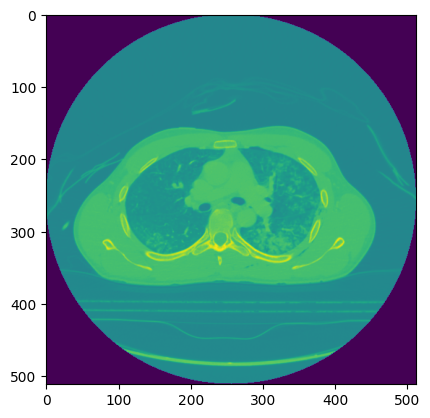

In [ ]:
plt.imshow(pixel_array)

In [ ]:
os.getcwd()

'G:\\'

483 (512, 512, 483)


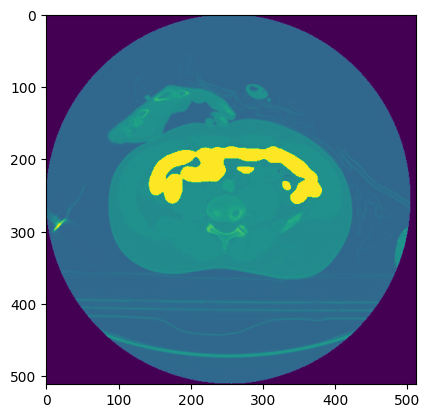

In [ ]:
idx = 250
s_id = seg_id[0]
p_id = s_id_p_id[s_id]
dcm_files = glob(f"./rsna-2023-abdominal-trauma-detection/train_images/{p_id}/{s_id}/*.dcm")
dcm_files = sorted(dcm_files, key = lambda x: int(x.split("\\")[-1].split(".")[0]))
dcm = dicomsdl.open(dcm_files[idx])
pixel_array = dicomsdl_to_numpy_image(dcm)
seg_im = nib.load(f"./rsna-2023-abdominal-trauma-detection/segmentations/{s_id}.nii").get_fdata().astype(int)[::-1,::-1, ::-1].transpose(1,0,2)
pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max()-pixel_array.min())
print(len(dcm_files), seg_im.shape)
plt.imshow(np.where(seg_im[:,:,idx]==0,pixel_array,1.0))#seg_im[:,:,idx]))

In [ ]:
seg_im[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import pydicom